# Few Shot Multi-Class Text Classification with BERT

In [1]:
import os
import json
import pandas as pd
import numpy as np

from tqdm.auto import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from transformers import BertTokenizerFast as BertTokenizer, BertForSequenceClassification, BertModel, AdamW, get_linear_schedule_with_warmup

import pytorch_lightning as pl
from pytorch_lightning.metrics.functional import accuracy, f1, auroc
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, multilabel_confusion_matrix

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib.pyplot import figure

%matplotlib inline

RANDOM_SEED = 123

pl.seed_everything(RANDOM_SEED)
pd.options.display.max_colwidth = 100

Global seed set to 123


In [2]:
# Require to change: 
parent_dir = PATH+'/multilabel_class_part1'
train_path = parent_dir + '/oos-eval/data/data_full.json'
test_path = parent_dir + 'test.csv'
logging_path = 'lightning_logs_test'
checkpoint_path = 'checkpoints_test'
BERT_MODEL_NAME = 'bert-base-cased'
MAX_TOKEN_COUNT = 300
N_EPOCHS = 5
BATCH_SIZE = 6
pretrained_checkpoint = PATH+"checkpoints_banking/best-checkpoint.ckpt"

In [3]:
LABEL_COLUMNS = [
        "replacement_card_duration",
        "expiration_date",
        "damaged_card",
        "improve_credit_score",
        "report_lost_card",
        "card_declined",
        "credit_limit_change",
        "apr",
        "redeem_rewards",
        "credit_limit",
        "rewards_balance",
        "application_status",
        "credit_score",
        "new_card",
        "international_fees"
    ]

In [4]:
# Format Data into dataframe
f = open(train_path)
data = json.load(f)

text = []
category = [] 

for element in data.keys():
    for each_row in data[element]:
        if each_row[1] in LABEL_COLUMNS: 
            text.append(each_row[0])
            category.append(each_row[1])

            df = pd.DataFrame(
    {'text': text,
     'category': category
    })

## Data Processing

Let's take a look at the dataset

In [5]:
df = df.sample(frac=1).reset_index(drop=True)
df_train, df_test = train_test_split(df, test_size=0.3)
df_train[5:10]

,text,category
326,how do i locate my current credit score,credit_score
1507,can you increase my credit limit,credit_limit_change
1240,what is the status of my credit card application looking like,application_status
1366,my card is damaged and unusable,damaged_card
521,how can i look at rewards for my amex card,rewards_balance


In [6]:
# Get questions and intents in list 
train_questions = list(df_train['text'])
train_intents = list(df_train['category'])
test_questions = list(df_test['text'])
test_intents = list(df_test['category'])

In [7]:
# Examine the total values of the category
df_train.groupby('category').count()['text'].sort_values()

category
damaged_card                 101
improve_credit_score         101
rewards_balance              101
international_fees           102
new_card                     102
replacement_card_duration    103
apr                          104
application_status           105
redeem_rewards               106
card_declined                107
credit_limit_change          107
expiration_date              107
credit_score                 108
report_lost_card             110
credit_limit                 111
Name: text, dtype: int64

In [8]:
possible_labels = df_train['category'].unique()
LABEL_COLUMNS = possible_labels

label_dict = {}
for index, possible_label in enumerate(possible_labels):
    label_dict[possible_label] = index
label_dict

{'expiration_date': 0,
 'apr': 1,
 'redeem_rewards': 2,
 'credit_limit': 3,
 'credit_score': 4,
 'credit_limit_change': 5,
 'application_status': 6,
 'damaged_card': 7,
 'rewards_balance': 8,
 'replacement_card_duration': 9,
 'card_declined': 10,
 'new_card': 11,
 'improve_credit_score': 12,
 'international_fees': 13,
 'report_lost_card': 14}

In [10]:
df_train['label'] = df_train['category'].replace(label_dict)
df_test['label'] = df_test['category'].replace(label_dict)
df_train

/ssd003/home/elau/Conv_BERT/BERT_MLM_env/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/ssd003/home/elau/Conv_BERT/BERT_MLM_env/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,text,category,label
1120,when is my card expired,expiration_date,0
204,does my apr rate suck,apr,1
590,when is my credit card set to expire,expiration_date,0
1488,how can i claim my rewards for my visa card,redeem_rewards,2
258,tell me my credit limit,credit_limit,3
...,...,...,...
320,what are some way s i can do to improe my credit score,improve_credit_score,12
660,what's the limit on my american express card,credit_limit,3
401,how do i utilize my credit card points,redeem_rewards,2
1327,where's my credit score,credit_score,4


In [11]:
train_df, val_df = train_test_split(df_train, test_size=0.05)
test_df = df_test

### Tokenization


In [12]:
tokenizer = BertTokenizer.from_pretrained(BERT_MODEL_NAME)

In [13]:
sample_row = train_df.iloc[15]
sample_comment = sample_row.text
sample_labels = sample_row.category

print(sample_comment)
print(sample_labels)

i need to know when my card is set to expire please
expiration_date


In [14]:
encoding = tokenizer.encode_plus(
  sample_comment,
  add_special_tokens=True,
  max_length=300,
  return_token_type_ids=False,
  padding="max_length",
  return_attention_mask=True,
  return_tensors='pt',
)

In [15]:
print(encoding["input_ids"].shape, encoding["attention_mask"].shape)

torch.Size([1, 300]) torch.Size([1, 300])


In [16]:
print(encoding["input_ids"].squeeze()[:50])
print(encoding["attention_mask"].squeeze()[:50])

tensor([  101,   178,  1444,  1106,  1221,  1165,  1139,  3621,  1110,  1383,
         1106,  4252, 20082,  4268,   102,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0])
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0])


In [17]:
print(tokenizer.convert_ids_to_tokens(encoding["input_ids"].squeeze())[:20])

['[CLS]', 'i', 'need', 'to', 'know', 'when', 'my', 'card', 'is', 'set', 'to', 'ex', '##pire', 'please', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']


26


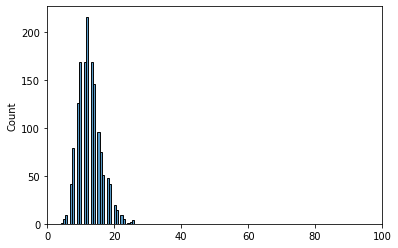

In [18]:
# Distribution of the tokenized sentences
token_counts = []

for _, row in train_df.iterrows():
  token_count = len(tokenizer.encode(
    row["text"], 
    max_length=512, 
    truncation=True
  ))
  token_counts.append(token_count)

sns.histplot(token_counts)
print(max(token_counts))
plt.xlim([0, 100]);

### Dataset

In [19]:
class Generic_Dataset(Dataset):

  def __init__(
    self, 
    data: pd.DataFrame, 
    tokenizer: BertTokenizer, 
    max_token_len: int = 128
  ):
    self.tokenizer = tokenizer
    self.data = data
    self.max_token_len = max_token_len
    
  def __len__(self):
    return len(self.data)

  def __getitem__(self, index: int):
    data_row = self.data.iloc[index]

    comment_text = data_row.text
    labels = data_row.label

    encoding = self.tokenizer.encode_plus(
      comment_text,
      add_special_tokens=True,
      max_length=self.max_token_len,
      return_token_type_ids=False,
      padding="max_length",
      truncation=True,
      return_attention_mask=True,
      return_tensors='pt',
    )
    return dict(
      comment_text=comment_text,
      input_ids=encoding["input_ids"].flatten(),
      attention_mask=encoding["attention_mask"].flatten(),
      labels=torch.tensor(labels)
    )

In [20]:
train_dataset = Generic_Dataset(
  train_df,
  tokenizer,
  max_token_len=MAX_TOKEN_COUNT
)

sample_item = train_dataset[0]
sample_item.keys()

dict_keys(['comment_text', 'input_ids', 'attention_mask', 'labels'])

In [21]:
print(sample_item["comment_text"])
print(sample_item["labels"])
print(sample_item["input_ids"].shape)

tell me if the following thing can hurt my credit score
tensor(12)
torch.Size([300])


In [22]:
class Generic_DataModule(pl.LightningDataModule):

  def __init__(self, train_df, test_df, tokenizer, batch_size=8, max_token_len=128):
    super().__init__()
    self.batch_size = batch_size
    self.train_df = train_df
    self.test_df = test_df
    self.tokenizer = tokenizer
    self.max_token_len = max_token_len

  def setup(self, stage=None):
    self.train_dataset = Generic_Dataset(
      self.train_df,
      self.tokenizer,
      self.max_token_len
    )

    self.test_dataset = Generic_Dataset(
      self.test_df,
      self.tokenizer,
      self.max_token_len
    )

  def train_dataloader(self):
    return DataLoader(
      self.train_dataset,
      batch_size=self.batch_size,
      shuffle=True,
      num_workers=2
    )

  def val_dataloader(self):
    return DataLoader(
      self.test_dataset,
      batch_size=self.batch_size,
      num_workers=2
    )

  def test_dataloader(self):
    return DataLoader(
      self.test_dataset,
      batch_size=self.batch_size,
      num_workers=2
    )

In [23]:
data_module = Generic_DataModule(
  train_df,
  val_df,
  tokenizer,
  batch_size=BATCH_SIZE,
  max_token_len=MAX_TOKEN_COUNT
)

## Model

In [24]:
class BERTPred(nn.Module):

  def __init__(self, n_classes: int, n_training_steps=None, n_warmup_steps=None):
    super().__init__()
    self.bert = BertModel.from_pretrained(BERT_MODEL_NAME, return_dict=True)
    self.classifier = nn.Linear(self.bert.config.hidden_size, n_classes)
    self.n_training_steps = n_training_steps
    self.n_warmup_steps = n_warmup_steps
    self.criterion = nn.BCELoss()

  def forward(self, input_ids, attention_mask, labels=None):
    output = self.bert(input_ids, attention_mask=attention_mask, output_hidden_states=True, output_attentions=True)
    loss = 0
    if labels is not None:
        loss = self.criterion(output, labels)
    return output

In [25]:
class Tagger(pl.LightningModule):

  def __init__(self, n_classes: int, n_training_steps=None, n_warmup_steps=None):
    super().__init__()
    chk_path = pretrained_checkpoint
    checkpoint = torch.load(chk_path, map_location=torch.device('cpu'))
    self.bert = BERTPred(77)
    self.load_state_dict(torch.load('banking_saved.bin'))
#     Freezing
    for self.param in self.bert.bert.parameters():
        self.param.requires_grad = False
    self.classifier = nn.Linear(768, n_classes)
    self.n_training_steps = n_training_steps
    self.n_warmup_steps = n_warmup_steps
    self.criterion = nn.CrossEntropyLoss()

  def forward(self, input_ids, attention_mask, labels=None):
    output = self.bert(input_ids, attention_mask=attention_mask)
    cls_representation = output[1]
    output = self.classifier(cls_representation)
    loss = 0
    if labels is not None:
        loss = self.criterion(output, labels)
    return loss, output

  def training_step(self, batch, batch_idx):
    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    labels = batch["labels"]
    loss, outputs = self(input_ids, attention_mask, labels)
    self.log("train_loss", loss, prog_bar=True, logger=True)
    return {"loss": loss, "predictions": outputs, "labels": labels}

  def validation_step(self, batch, batch_idx):
    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    labels = batch["labels"]
    loss, outputs = self(input_ids, attention_mask, labels)
    self.log("val_loss", loss, prog_bar=True, logger=True)
    return loss

  def test_step(self, batch, batch_idx):
    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    labels = batch["labels"]
    loss, outputs = self(input_ids, attention_mask, labels)
    self.log("test_loss", loss, prog_bar=True, logger=True)
    return loss

  def configure_optimizers(self):
    optimizer = AdamW(self.parameters(), lr=0.001)
    scheduler = get_linear_schedule_with_warmup(
      optimizer,
      num_warmup_steps=self.n_warmup_steps,
      num_training_steps=self.n_training_steps
    )

    return dict(
      optimizer=optimizer,
      lr_scheduler=dict(
        scheduler=scheduler,
        interval='step'
      )
  )

In [26]:
steps_per_epoch=len(train_df) // BATCH_SIZE
total_training_steps = steps_per_epoch * N_EPOCHS

warmup_steps = total_training_steps // 5
warmup_steps, total_training_steps

(249, 1245)

In [27]:
# Create an instance of the model
model = Tagger(
  n_classes=len(LABEL_COLUMNS),
  n_warmup_steps=warmup_steps,
  n_training_steps=total_training_steps 
)


## Training

In [28]:
!rm -rf logging_path/
!rm -rf checkpoint_path/

%load_ext tensorboard
%tensorboard --logdir ./logging_path

Reusing TensorBoard on port 6006 (pid 502), started 10:02:20 ago. (Use '!kill 502' to kill it.)

In [29]:
checkpoint_callback = ModelCheckpoint(
  dirpath=checkpoint_path,
  filename="best-checkpoint",
  save_top_k=1,
  verbose=True,
  monitor="val_loss",
  mode="min"
)

/ssd003/home/elau/Conv_BERT/BERT_MLM_env/lib/python3.6/site-packages/pytorch_lightning/utilities/distributed.py:68: UserWarning: Checkpoint directory checkpoints_OOS exists and is not empty.
  warnings.warn(*args, **kwargs)


In [30]:
logger = TensorBoardLogger(logging_path, name="classification")

In [31]:
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=2)

In [32]:
# Training
trainer = pl.Trainer(
  logger=logger,
  checkpoint_callback=checkpoint_callback,
  callbacks=[early_stopping_callback],
  max_epochs=N_EPOCHS,
  gpus=1,
  progress_bar_refresh_rate=30
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores


In [33]:
trainer.fit(model, data_module)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.

  | Name       | Type             | Params
------------------------------------------------
0 | bert       | BERTPred         | 108 M 
1 | classifier | Linear           | 11.5 K
2 | criterion  | CrossEntropyLoss | 0     
------------------------------------------------
70.7 K    Trainable params
108 M     Non-trainable params
108 M     Total params
433.524   Total estimated model params size (MB)
/ssd003/home/elau/Conv_BERT/BERT_MLM_env/lib/python3.6/site-packages/pytorch_lightning/utilities/distributed.py:68: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Validation sanity check: 0it [00:00, ?it/s]

/ssd003/home/elau/Conv_BERT/BERT_MLM_env/lib/python3.6/site-packages/pytorch_lightning/utilities/distributed.py:68: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Epoch 0, global step 249: val_loss reached 0.70185 (best 0.70185), saving model to "/ssd003/home/elau/Conv_BERT/ConversationalAI/intentIdentification/predefinedClassification/checkpoints_OOS/best-checkpoint-v6.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 1, global step 499: val_loss reached 0.48680 (best 0.48680), saving model to "/ssd003/home/elau/Conv_BERT/ConversationalAI/intentIdentification/predefinedClassification/checkpoints_OOS/best-checkpoint-v6.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 2, global step 749: val_loss reached 0.45643 (best 0.45643), saving model to "/ssd003/home/elau/Conv_BERT/ConversationalAI/intentIdentification/predefinedClassification/checkpoints_OOS/best-checkpoint-v6.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 3, global step 999: val_loss reached 0.43855 (best 0.43855), saving model to "/ssd003/home/elau/Conv_BERT/ConversationalAI/intentIdentification/predefinedClassification/checkpoints_OOS/best-checkpoint-v6.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 4, global step 1249: val_loss reached 0.41001 (best 0.41001), saving model to "/ssd003/home/elau/Conv_BERT/ConversationalAI/intentIdentification/predefinedClassification/checkpoints_OOS/best-checkpoint-v6.ckpt" as top 1


1

In [34]:
# Check validation loss
trainer.test()

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ssd003/home/elau/Conv_BERT/BERT_MLM_env/lib/python3.6/site-packages/pytorch_lightning/utilities/distributed.py:68: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.4100111126899719}
--------------------------------------------------------------------------------


[{'test_loss': 0.4100111126899719}]

## Predictions

In [35]:
trained_model = Tagger.load_from_checkpoint(
  trainer.checkpoint_callback.best_model_path,
  n_classes=len(LABEL_COLUMNS)
)
trained_model.eval()
trained_model.freeze()

## Evaluation

In [36]:
THRESHOLD = 0.5
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
trained_model = trained_model.to(device)

val_dataset = Generic_Dataset(
  test_df,
  tokenizer,
  max_token_len=MAX_TOKEN_COUNT
)

predictions = []
labels = []

for item in tqdm(val_dataset):
    _ , prediction = trained_model(
    item["input_ids"].unsqueeze(dim=0).to(device), 
    item["attention_mask"].unsqueeze(dim=0).to(device),
    item["labels"].unsqueeze(dim=0).to(device)
    )
    predictions.append(torch.max(prediction, dim=1).indices.int()[0])
    labels.append(item["labels"].int())

predictions = torch.stack(predictions).detach().cpu()
labels = torch.stack(labels).detach().cpu()

  0%|          | 0/675 [00:00<?, ?it/s]

In [37]:
accuracy(predictions, labels)

tensor(0.8963)

In [38]:
y_pred = predictions.numpy().copy()
y_true = labels.numpy().copy()

print(classification_report(
  y_true, 
  y_pred, 
  target_names=LABEL_COLUMNS, 
  zero_division=0
))

                           precision    recall  f1-score   support

          expiration_date       0.93      0.95      0.94        43
                      apr       0.93      0.89      0.91        46
           redeem_rewards       0.90      0.80      0.84        44
             credit_limit       0.65      0.92      0.77        39
             credit_score       0.84      1.00      0.91        42
      credit_limit_change       0.90      0.63      0.74        43
       application_status       0.98      0.96      0.97        45
             damaged_card       0.92      0.94      0.93        49
          rewards_balance       0.88      0.78      0.83        49
replacement_card_duration       0.88      0.94      0.91        47
            card_declined       1.00      0.95      0.98        43
                 new_card       0.85      0.98      0.91        48
     improve_credit_score       0.98      0.84      0.90        49
       international_fees       0.94      0.98      0.96     